In [2]:
import pandas as pd
import yfinance as yf
import datetime
import time
import requests
import io

In [3]:
### To download data for the stocks
Symbols = ["AAPL","GOOGL","FB"]
start = datetime.datetime(2020,2,1)
end = datetime.datetime(2020,10,11)

stock_final = pd.DataFrame()
# iterate over each symbol
for i in Symbols:  
    
    # print the symbol which is being downloaded
    print( str(Symbols.index(i)) + str(' : ') + i, sep=',', end=',', flush=True)  
    
    try:
        # download the stock price 
        stock = []
        stock = yf.download(i,start=start, end=end, progress=True)
        
        # append the individual stock prices 
        if len(stock) == 0:
            None
        else:
            stock['Name']=i
            stock_final = stock_final.append(stock,sort=False)
    except Exception:
        None
        

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
# This contains data for all the stocks
stock_final.head()

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2020-01-31,80.232498,80.669998,77.072502,77.377502,76.244957,199588400,AAPL
2020-02-03,76.074997,78.372498,75.555000,77.165001,76.035576,173788400,AAPL
2020-02-04,78.827499,79.910004,78.407501,79.712502,78.545776,136616400,AAPL
2020-02-05,80.879997,81.190002,79.737503,80.362503,79.186249,118826800,AAPL
2020-02-06,80.642502,81.305000,80.065002,81.302498,80.112503,105425600,AAPL


In [5]:
#Seperate the data for each stock/company
google = stock_final[stock_final["Name"]=="GOOGL"]
google.head()

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2020-01-31,1467.859985,1469.670044,1427.060059,1432.780029,1432.780029,2191100,GOOGL
2020-02-03,1461.650024,1486.300049,1456.609985,1482.599976,1482.599976,3581800,GOOGL
2020-02-04,1454.489990,1467.339966,1422.030029,1445.410034,1445.410034,4794000,GOOGL
2020-02-05,1463.609985,1464.579956,1429.680054,1446.050049,1446.050049,1818800,GOOGL
2020-02-06,1451.979980,1481.560059,1450.479980,1475.969971,1475.969971,1891100,GOOGL


In [6]:
facebook = stock_final[stock_final["Name"]=="FB"]
facebook.head()

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2020-01-31,208.429993,208.690002,201.059998,201.910004,201.910004,31359900,FB
2020-02-03,203.440002,205.139999,202.500000,204.190002,204.190002,15495600,FB
2020-02-04,206.619995,210.600006,205.199997,209.830002,209.830002,19628900,FB
2020-02-05,212.509995,212.729996,208.710007,210.110001,210.110001,12538200,FB
2020-02-06,210.470001,211.190002,209.339996,210.850006,210.850006,10567500,FB


In [7]:
apple = stock_final[stock_final["Name"]=="AAPL"]
apple.head()

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2020-01-31,80.232498,80.669998,77.072502,77.377502,76.244957,199588400,AAPL
2020-02-03,76.074997,78.372498,75.555000,77.165001,76.035576,173788400,AAPL
2020-02-04,78.827499,79.910004,78.407501,79.712502,78.545776,136616400,AAPL
2020-02-05,80.879997,81.190002,79.737503,80.362503,79.186249,118826800,AAPL
2020-02-06,80.642502,81.305000,80.065002,81.302498,80.112503,105425600,AAPL


#### Studying the spread between each pair of stocks

In [8]:
AF_spread = apple.Close - facebook.Close

In [9]:
AG_spread = apple.Close - google.Close

In [10]:
GF_spread = google.Close - facebook.Close

In [11]:
AF_spread.head()

Date
2020-01-31   -124.532501
2020-02-03   -127.025002
2020-02-04   -130.117500
2020-02-05   -129.747498
2020-02-06   -129.547508
Name: Close, dtype: float64

In [12]:
## the most cointegrated pair
stock1 = pd.read_csv('data/2021-december/PKI.csv')
stock2 = pd.read_csv('data/2021-december/S.csv')
beta = 3.8312600785683832

In [13]:
spread = stock1.Close - beta * stock2.Close

### Checking for stationarity over spreads

In [10]:
import matplotlib.pyplot as plt

The mean of the spread is : 0.21564519689464232


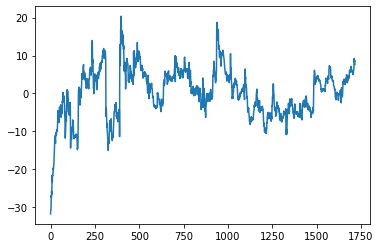

In [15]:
print("The mean of the spread is :",spread.mean())
plt.plot(spread)
plt.show()

The mean of the spread is : -1320.6718361160972


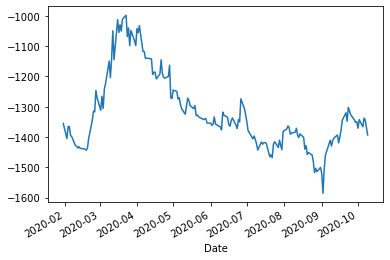

In [16]:
print("The mean of the spread is :",AG_spread.mean())
AG_spread.plot()
plt.show()

The mean of the spread is : 1186.502104845914


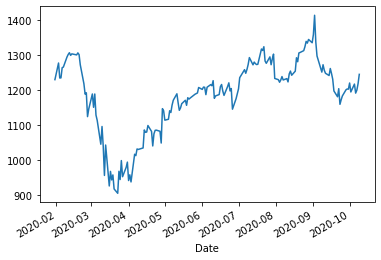

In [17]:
print("The mean of the spread is :",GF_spread.mean())
GF_spread.plot()
plt.show()

#### ADFULLER TEST

In [18]:

from statsmodels.tsa.stattools import adfuller
result = adfuller(spread)

In [19]:
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.503918
p-value: 0.000002
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


#### The most cointegrated pair based on the data of 2021-12-28 is ('BBBY', 'MCK')

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from collections import deque
import random
import pandas as pd
import numpy as np
import torch.optim as optim

In [81]:
class DQN(nn.Module):
    def __init__(self):
        super().__init__()
        # Defining network to optimize our Q function
        self.input = nn.Linear(12,50)
        self.dense1 = nn.Linear(50,50)
        self.out = nn.Linear(50, 3)
    ## Forward propagation
    def forward(self, x):
        x = self.input(x)
        x = F.relu(x)
        x = self.dense1(x)
        x = F.relu(x)
        x = self.out(x)

        return x
    ## Train model
    def train(self,X,Y):
        criterion = nn.HuberLoss()
        optimizer = optim.Adam(self.parameters(), lr=0.002)
        running_loss = 0.0
        for i in range(len(X)):
            inputs, labels= torch.FloatTensor(X[i]), torch.FloatTensor(Y[i])
            optimizer.zero_grad()
            out = self.forward(inputs)
            loss = criterion(out, labels)
            loss.backward()          ## This does back propagation
            optimizer.step()         ## To optimize loss function 
            running_loss+=loss.item()  ## the value of the loss function after training
        
        return running_loss
    
    

In [239]:
import random
class Agent:
    def __init__(self, state_size,window_size,trend, skip,batch_size,stock1,stock2):
        self.stock1 = stock1
        self.stock2 = stock2
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3 
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []
        self.gamma = 0.8
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999
        self.model = DQN()
        
    def act(self,state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return torch.argmax(self.model(torch.FloatTensor(state)))
    
    def get_state(self,t):
        current_mean = sum(self.trend[:t+1])/len(self.trend[:t+1])
        
        
        daily_returns = self.trend[t] - self.trend[t-1] if t >= 1 else 0.0
        spread_mean_30 = sum(self.trend[t-29:t+1]) / 30 if t>=30 else sum(self.trend[:t+1])/(t+1)
        mean_over_30 = current_mean/spread_mean_30
        spread_mean_20 = sum(self.trend[t-19:t+1]) / 20 if t>=20 else sum(self.trend[:t+1])/(t+1)
        mean_over_20 = current_mean/spread_mean_20
        spread_mean_15 = sum(self.trend[t-14:t+1]) / 15 if t>=15 else sum(self.trend[:t+1]) /(t+1)
        mean_over_15 = current_mean / spread_mean_15
        spread_mean_10 = sum(self.trend[t-9:t+1]) / 10 if t>=10 else sum(self.trend[:t+1]) /(t+1)
        mean_over_10 = current_mean/spread_mean_10
        spread_mean_7 = sum(self.trend[t-6:t+1]) / 7 if t>=7 else sum(self.trend[:t+1]) /(t+1)
        mean_over_7 = current_mean/spread_mean_7
        spread_mean_5 = sum(self.trend[t-4:t+1]) / 7 if t>=5 else sum(self.trend[:t+1]) /(t+1)
        mean_over_5 = current_mean/spread_mean_5
        
        state = [self.trend[t],daily_returns,
                 spread_mean_20,mean_over_20,
                 spread_mean_15,mean_over_15,
                 spread_mean_10,mean_over_10,
                 spread_mean_7,mean_over_7,
                 spread_mean_5,mean_over_5]
        
        return np.array([state])
    
    def buy(self,initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory1 = [self.stock1[0]]
        inventory2=[]
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and starting_money >= abs(self.trend[t]) and len(inventory2)>0:
                bought_price = inventory2.pop(0)
                inventory1.append(self.stock1[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 sell 2 at difference %f, total balance %f'% (t, self.trend[t], initial_money))
                
            elif action == 2 and starting_money >= abs(self.trend[t]) and len(inventory1)>0:
                bought_price = inventory1.pop(0)
                inventory2.append(self.stock2[t])
                initial_money += self.trend[t]
                states_sell.append(t)
                print('day %d: buy 2 sell 1 at difference %f, total balance %f'% (t, self.trend[t], initial_money))
                
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
    
    def replay(self,batch_size):
        ## Add randomization for the data taken for training
        mini_batch = []
        l = len(self.memory)
        for i in range(l-batch_size,l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.model(torch.FloatTensor(states)).tolist()
        Q_new = self.model(torch.FloatTensor(new_states)).tolist()

        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            
            if not done:
                target[action] += self.gamma * max(Q_new[i])
            X[i] = state
            Y[i] = target
        cost = self.model.train(X,Y)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    
    def train(self, iterations, checkpoint, initial_money):
        
        for i in range(iterations):
            number_of_actions = 0
            total_profit = 0
            inventory1 = [self.stock1[0]]
            inventory2 = [self.stock2[0]]
            state = self.get_state(0)
            starting_money = initial_money
            money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                ## Check if the action is 1 and if I have enough money to execute the action
                if action == 1 and starting_money >= abs(self.trend[t]) and len(inventory2)>0:
                    number_of_actions +=1
                    bought_price = inventory2.pop(0)
                    inventory1.append(self.stock1[t])
                    starting_money -= self.trend[t]
                ## Check if the action is 2 and if I have enough money to execute the action
                elif action == 2 and starting_money >= abs(self.trend[t]) and len(inventory1)>0:
                    number_of_actions +=1
                    bought_price = inventory1.pop(0)
                    inventory2.append(self.stock2[t])
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)

                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                random.shuffle(self.memory)
                cost = self.replay(batch_size)   
            total_profit = starting_money-initial_money
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f, The number of taken actions: %d'%(i + 1, total_profit, cost,
                                                                                  starting_money,number_of_actions))               
                

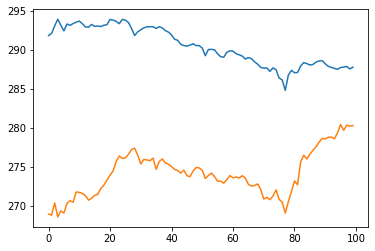

In [250]:
stock2 = pd.read_csv('data/2021-december/NSC.csv')
stock1 = pd.read_csv('data/2021-december/APD.csv')
beta = 0.9652687759930171
plt.plot(stock1.Close[:100])
plt.plot(stock2.Close[:100])
plt.show()

In [223]:
spread = stock1.Close - stock2.Close

The mean of the spread is : 0.009613710227453082


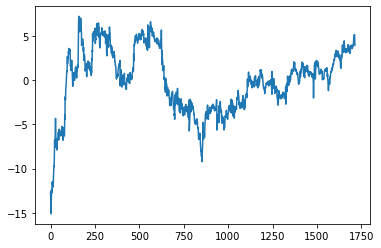

In [210]:
print("The mean of the spread is :",spread.mean())
plt.plot(spread)
plt.show()

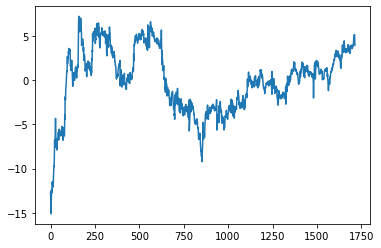

In [211]:
#plt.plot(stock1.Close)
#plt.plot(stock2.Close)
plt.plot(stock1.Close - beta * stock2.Close)
plt.show()

In [212]:
## Action 1: Buy first Sell second
## Action 2: Buy second Sell first
## Difference is first-second

700


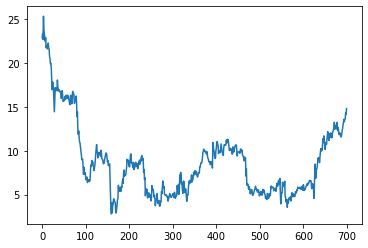

In [224]:
close = spread.values.tolist()[:700]
print(len(close))
plt.plot(close)

In [231]:
initial_money = 10000
window_size = 12
skip = 1
batch_size = 32
#stock1 = pd.read_csv('data/2021-december/PKI.csv').Close.tolist()
#stock2 = pd.read_csv('data/2021-december/S.csv').Close.tolist()
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size,
             stock1 = stock1.Close.tolist()[:700],
             stock2 = stock2.Close.tolist()[:700])

In [232]:
agent.train(iterations = 200, checkpoint = 5, initial_money = initial_money)

epoch: 5, total rewards: 27.635223.3, cost: 0.000045, total money: 10027.635223, The number of taken actions: 51
epoch: 10, total rewards: 25.093384.3, cost: 0.000015, total money: 10025.093384, The number of taken actions: 79
epoch: 15, total rewards: 19.330505.3, cost: 0.000011, total money: 10019.330505, The number of taken actions: 61
epoch: 20, total rewards: 24.715027.3, cost: 0.000011, total money: 10024.715027, The number of taken actions: 69
epoch: 25, total rewards: 20.308228.3, cost: 0.000007, total money: 10020.308228, The number of taken actions: 57
epoch: 30, total rewards: 20.544098.3, cost: 0.000015, total money: 10020.544098, The number of taken actions: 69
epoch: 35, total rewards: 18.579224.3, cost: 0.000014, total money: 10018.579224, The number of taken actions: 62


KeyboardInterrupt: 

In [233]:
agent.stock2 = stock2.Close.tolist()
agent.stock1 = stock1.Close.tolist()
agent.trend = spread.values.tolist()
print(len(agent.trend))
print(len(agent.stock1))
print(len(agent.stock2))

1715
1715
1715


In [246]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = 10000)

day 0: buy 2 sell 1 at difference 22.889984, total balance 10022.889984
day 250: buy 1 sell 2 at difference 4.275024, total balance 10018.614960
day 251: buy 2 sell 1 at difference 4.619995, total balance 10023.234955
day 316: buy 1 sell 2 at difference 7.233002, total balance 10016.001953
day 317: buy 2 sell 1 at difference 6.399994, total balance 10022.401947
day 447: buy 1 sell 2 at difference 10.044983, total balance 10012.356964
day 448: buy 2 sell 1 at difference 9.395020, total balance 10021.751984
day 778: buy 1 sell 2 at difference 14.709991, total balance 10007.041992
day 779: buy 2 sell 1 at difference 14.420013, total balance 10021.462006
day 1175: buy 1 sell 2 at difference 10.809998, total balance 10010.652008
day 1176: buy 2 sell 1 at difference 10.459991, total balance 10021.112000
day 1342: buy 1 sell 2 at difference 10.875000, total balance 10010.237000
day 1343: buy 2 sell 1 at difference 10.500000, total balance 10020.737000
day 1562: buy 1 sell 2 at difference 10.6

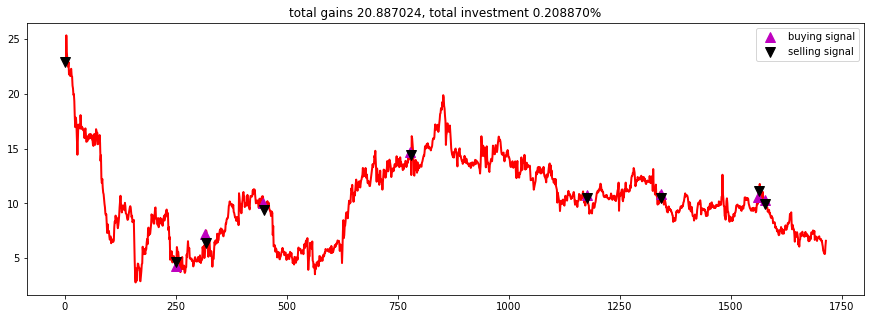

In [247]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15,5))
plt.plot(agent.trend, color='r', lw=2.)
plt.plot(agent.trend, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(agent.trend, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend(), '^'
plt.show()

In [237]:
states_buy

[64, 88, 169, 350, 367, 407, 511, 958, 1230, 1242, 1308]

In [238]:
states_sell

[0, 65, 89, 170, 351, 368, 408, 512, 959, 1231, 1243, 1309]

In [63]:
len(states_buy[4-3:4])

1